In [1]:
#Adornado B. Cabalbag Jr.
#BSIT-3B

Saving Tweets-Dataset (1).csv to Tweets-Dataset (1) (48).csv
+------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_text                                                                                                                    |text                                                                                                                                                   |
+------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|  when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run

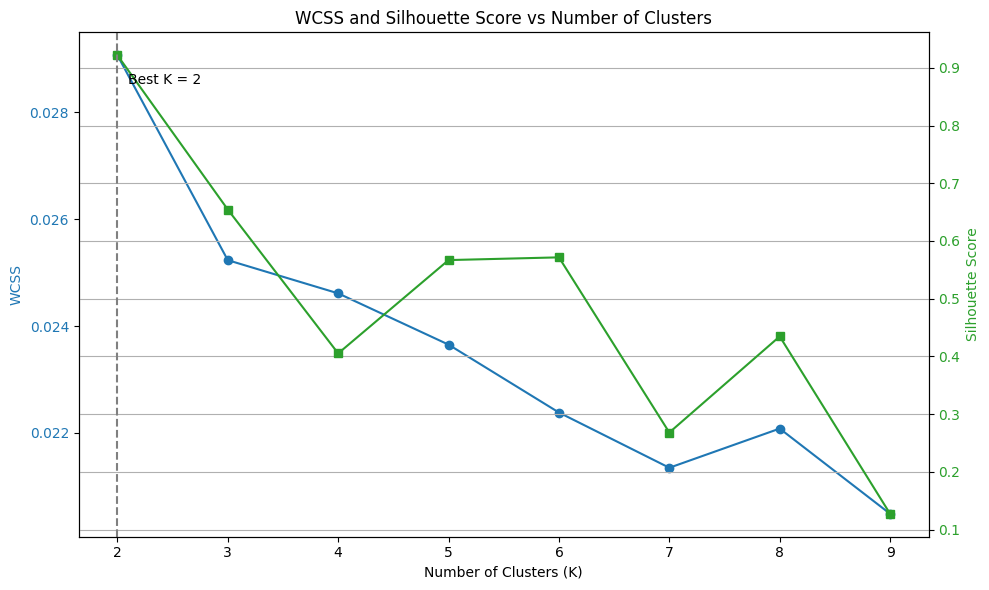

Final Silhouette Score: 0.9216
+------------------------------------------------------------------------------------------------------------------------------------+----------+
|clean_text                                                                                                                          |prediction|
+------------------------------------------------------------------------------------------------------------------------------------+----------+
|  when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run                                     |0         |
|  thanks for lyft credit i cant use cause they dont offer wheelchair vans in pdx    disapointed getthanked                          |0         |
|  bihday your majesty                                                                                                               |0         |
|model   i love u take with u all the time in ur                                             

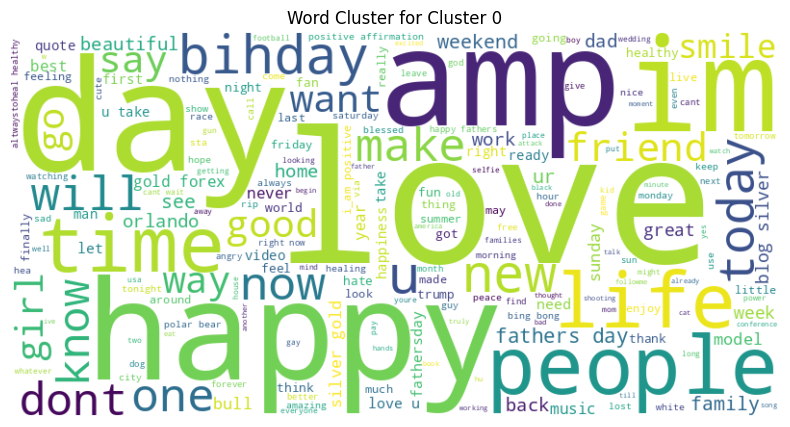

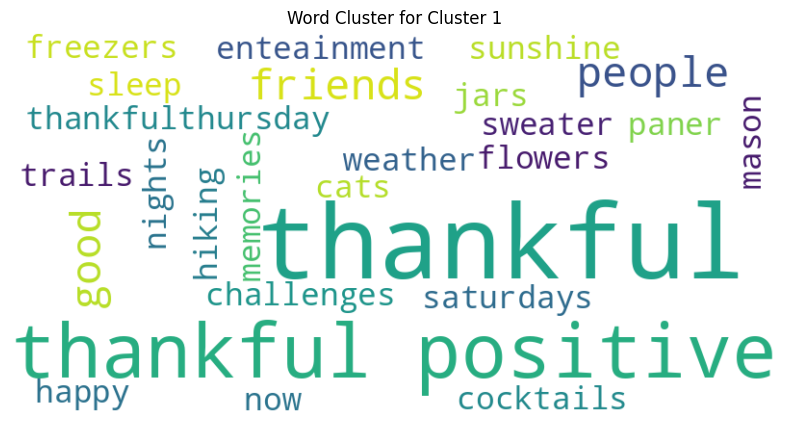

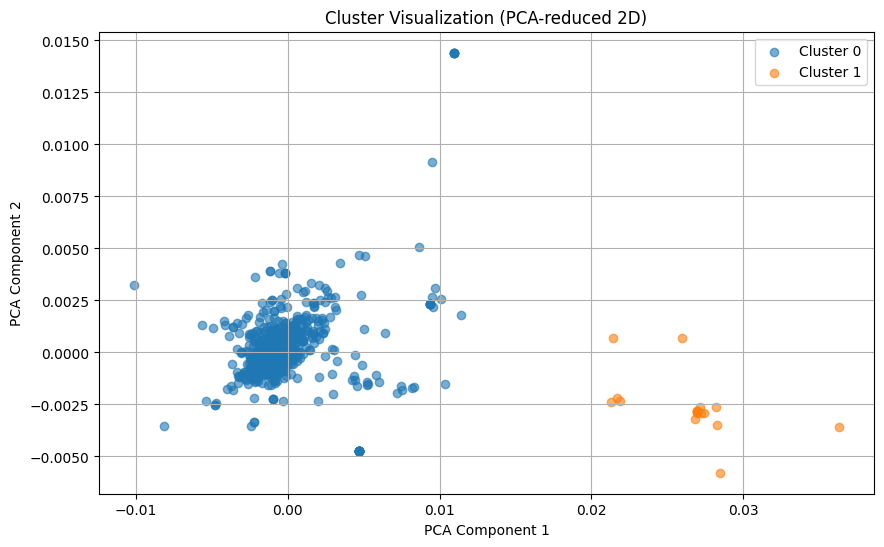

In [128]:
#Clustering using Word2Vec
#install required libraries

!pip install pyspark wordcloud matplotlib scikit-learn

# Import required libraries
import pandas as pd #pandas package
import numpy as np #numpy package
import matplotlib.pyplot as plt #matplotlib
from wordcloud import WordCloud
from google.colab import files

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, explode, expr
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator

from sklearn.decomposition import PCA

#Start Spark Session
spark = SparkSession.builder.appName("Word2Vec Clustering").getOrCreate()

#Upload CSV File
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df_pandas = pd.read_csv(file_name, encoding="ISO-8859-1")
df_pandas.columns = ["text"]

#Convert Spark DataFrame
df = spark.createDataFrame(df_pandas)

#Text Cleaning
clean_text = lower(col("text")).alias("clean_text")
clean_text = regexp_replace(clean_text, r"http\S+","")
clean_text = regexp_replace(clean_text, r"@\w+", "") # Modified to also remove potential trailing whitespace
#clean_text = regexp_replace(clean_text, r"#\w+","")
clean_text = regexp_replace(clean_text, r"[^\w\s]", "")
#clean_text = regexp_replace(clean_text, r"[^\x00-\x7F]+", "") # To remove non-ASCII characters like Ã
df = df.withColumn("clean_text", clean_text)

#Tokenization & Stopword
tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")

custom_stopwords = [ "the", "to", "i", "a", "you", "for", "and", "of", "in", "is", "it", "my", "s", "on", "all", "with",
    "that", "this", "are", "so", "t", "we", "your", "be", "day", "happy", "amp", "have", "at", "love",
    "not", "u", "me", "now", "about", "do", "just", "am", "will", "get", "m", "from", "people", "out",
    "when", "can", "they", "what", "time", "was","yeah", "oh", "okay", "ok", "yes", "no", "lol", "hmm", "uh", "uhh", "umm", "ah", "ha", "haha", "hehe", "hahaha",
    "he", "she", "his", "her", "they", "them", "their", "we", "our", "ours", "mine", "yours", "your", "us",
    "today", "tomorrow", "tonight", "yesterday", "morning", "evening", "night", "day", "week", "year",
    "here", "there", "where", "somewhere", "everywhere", "home", "place", "omg", "tgif"
    "can", "cant", "could", "would", "should", "may", "might", "shall", "must", "done", "did", "does", "isnt", "wasnt"]

default_stopwords = StopWordsRemover().getStopWords()
all_stopwords = list(set(default_stopwords + custom_stopwords))

stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=all_stopwords)
df.select("clean_text", "text").show(truncate=False)

#Fix nested arrays
df = tokenizer.transform(df)
df = stopwords_remover.transform(df)
df = df.withColumn("filtered_words", expr("filter(flatten(array(filtered_words)), x -> x is not null and trim(x) != '')"))
#and trim(x) != '')

df.select("clean_text","filtered_words").show(40, truncate=False)

#Word2Vec Embeddings
#Word2Vec transforms words into vector embeddings
#These vectors encodes semantic relationships between words
word2vec = Word2Vec(vectorSize=500, minCount=2, inputCol="filtered_words", outputCol="features")

#Elbow Method & Silhoutte
#Kmeans requries choosing a value of K (number of clusters).
#We evaluate cluster quality using:
# - WCSS (Within-Cluster Sum of Squares)
# - Silhouette Score (higher is better)

costs = []
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k, seed=42, maxIter=300)
    pipeline = Pipeline(stages=[word2vec, kmeans])
    model = pipeline.fit(df)
    result = model.transform(df)

    costs.append(model.stages[1].summary.trainingCost)

    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction")
    silhouette_scores.append(evaluator.evaluate(result))

#Plot WCSS & Silhouette Scores
# This helps identify the optimal K visually
fig, ax1 = plt.subplots(figsize=(10, 6))

color = "tab:blue"
ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("WCSS", color=color)
ax1.plot(k_values, costs, color=color, marker="o", label="WCSS")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("Silhouette Score", color=color)
ax2.plot(k_values, silhouette_scores, color=color, linestyle="-", marker="s", label="Silhouette Score")
ax2.tick_params(axis="y", labelcolor=color)

#Annotate best K
best_k = k_values[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
ax2.axvline(x=best_k, color="gray", linestyle="--")
ax2.text(best_k+0.1, best_score - 0.05, f"Best K = {best_k}", color="black")

plt.title("WCSS and Silhouette Score vs Number of Clusters")
fig.tight_layout()
plt.grid(True)
plt.show()

#Train Final KMeans
kmeans  = KMeans(featuresCol="features", predictionCol="prediction", k=best_k, seed=42, maxIter=300)
pipeline = Pipeline(stages=[word2vec, kmeans])
model = pipeline.fit(df)
result = model.transform (df)


#Final Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction")
silhouette_score = evaluator.evaluate(result)
print(f"Final Silhouette Score: {silhouette_score:.4f}")

#Show Cluster Assignments
result.select ("clean_text", "prediction").show(50, truncate=False)

#Top Words Per Cluster
result_pandas = result.select("clean_text", "prediction", "features").toPandas()
print("\nTop Words Per Cluster:")
for cluster_id in range(best_k):
  cluster_texts = result_pandas[result_pandas["prediction"]==cluster_id]["clean_text"].str.cat(sep=" ")
  words = cluster_texts.split()
  top_words = pd.Series(words).value_counts().head(10).index.tolist()
  print(f"Cluster {cluster_id}: {', '.join(top_words)}")

#Word Clouds per Cluster
for cluster_id in range(best_k):
  cluster_texts = result_pandas[result_pandas["prediction"]==cluster_id]["clean_text"].str.cat(sep=" ")
  wordcloud = WordCloud(width=800, height=400, background_color="white").generate(cluster_texts)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Word Cluster for Cluster {cluster_id}")
  plt.show()

#2D ClusterPlot using PCA
features = np.array(result_pandas["features"].tolist())
pca = PCA(n_components=2)
reduced = pca.fit_transform(features)

plt.figure(figsize=(10, 6))
for cluster_id in range(best_k):
  points = reduced[result_pandas["prediction"]==cluster_id]
  plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("Cluster Visualization (PCA-reduced 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()